### Transfer Learning with Tensorflow Part 2: Fine tuning

In the Previous Notebook, we covered transfer Learning Feature extraction, now it's time to learn about new kind of tranfer learning: fine Tuning

### Creating helper functions

In previous Notebook's, we've created a bunch of helper functions, now we could rewrite them all, however,this is tedious.

so, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere)


we've done this for some of the functions we've used previously in helper_function.py

In [45]:
import wget
url="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
filename=wget.download(url)
print(filename)

100% [..............................................................................] 10246 / 10246helper_functions (1).py


In [46]:
#import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

### Let's get some Data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
#Get 10% of training data of 10 classes of food101

url="https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
filename=wget.download(url)
print(filename)

100% [......................................................................] 168546183 / 16854618310_food_classes_10_percent (1).zip


In [4]:
unzip_data(filename)

In [47]:
#Check out how many images and subdirectories are in our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [48]:
#Create training and test directory paths

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [49]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode="categorical",
                                                                         batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                             image_size=IMG_SIZE,
                                                             label_mode="categorical",
                                                             batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [50]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [51]:
#Check out the calss names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [52]:
#See an example of a batch of data   #take() will unravel the batch
for images, labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [1.30000000e+01 1.40000000e+01 8.00000000e+00]
   [1.30000000e+01 1.40000000e+01 8.00000000e+00]
   [1.30000000e+01 1.40000000e+01 8.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [1.37857056e+01 1.40000000e+01 6.00000000e+00]
   [1.30000000e+01 1.40000000e+01 6.00000000e+00]
   [1.30000000e+01 1.40000000e+01 6.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [1.44285717e+01 1.37857141e+01 6.00000000e+00]
   [1.44285717e+01 1.37857141e+01 6.00000000e+00]
   [1.40000000e+01 1.40000000e+01 6.00000000e+00]]

  ...

  [[9.32437820e+01 9.10295181e+01 7.76009903e+01]
   [1

#Modeling experiments we're running

Experiment-------->data--------->preprocessing-------->Model


model_0(baseline)---10classes of Food101data(random 10% training data only)----None----Feature Extractor:EfficientNetB0(pretrained on ImageNet,all layers frozen) with no top


model_1----10classes of food101 data (random 1% training data only)---Random Flip,Rotation,Zoom,Height,Width,data augmentation-----same as Model_0


model_2----same as model_0--------same as model_1-------same as model_0


model_3--------same as model_0-------same as model_1------Fine-tuning:Model2(EfficientnetB0 pre-trained on ImageNet) with top layer trained on custom data,top 10 layers unfrozen


model_4-------10classes of Food101 data(100% training data)----same as model1------same as model3

### Keras Sequential API vs. Functional API

* similarities: compiling,fitting,evaluating
* Differences: model construction (the Functional API is more flexible and able to produce more sophisticated models)

#Model_0: Building a transfer learning feature extraction model using the keras Functional API

The sequential API is straight-forward, it runs our layers in Sequential order.

But the functional API gives us more flexibility with our models

In [53]:
# 1. Create base model with tf.keras.applications
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns/weights aren't updated during traing )
base_model.trainable=False

# 3. Create inputs into our model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. if using model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNets,Rescaling built in)
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x=base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. Average Pool the outputs of the base model(aggregate all the most important information,reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")

# 7. Create the output activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)
  
# 8. Combine the inputs with the outputs into a model
model_0=tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

# 10. Fit the model and save it's history
history_10_percent=model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="Transfer_learning",
                                                                    experiment_name="10_percent_feature_ectraction")])

Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: Transfer_learning/10_percent_feature_ectraction/20230315-071011
Epoch 1/5
24/24 [==============================] - 7s 132ms/step - loss: 1.8113 - accuracy: 0.4640 - val_loss: 1.2623 - val_accuracy: 0.7516
Epoch 2/5
24/24 [==============================] - 2s 96ms/step - loss: 1.0444 - accuracy: 0.7853 - val_loss: 0.8475 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 2s 96ms/step - loss: 0.7614 - accuracy: 0.8253 - val_loss: 0.7124 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 2s 95ms/step - loss: 0.6130 - accuracy: 0.8640 - val_loss: 0.6256 - val_accuracy: 0.8470
Epoch 5/5
24/24 [==============================] - 2s 95ms/step - loss: 0.5260 - accuracy: 0.8867 - val_loss: 0.5735 - val_accuracy: 0.8536


In [54]:
#Evaluate the model
model_0.evaluate(test_data)

79/79 [==============================] - 4s 49ms/step - loss: 0.5465 - accuracy: 0.8592


[0.5465483665466309, 0.8592000007629395]

In [55]:
#Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_3
1 rescaling_4
2 normalization_2
3 rescaling_5
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [56]:
#How about we get the summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

                                                                                                  
 block2a_se_excite (Multiply)   (None, None, None,   0           ['block2a_activation[0][0]',     
                                96)                               'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, None, None,   2304        ['block2a_se_excite[0][0]']      
                                24)                                                               
                                                                                                  
 block2a_project_bn (BatchNorma  (None, None, None,   96         ['block2a_project_conv[0][0]']   
 lization)                      24)                                                               
                                                                                                  
 block2b_e

                                144)                              'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, None, None,   5760        ['block3a_se_excite[0][0]']      
                                40)                                                               
                                                                                                  
 block3a_project_bn (BatchNorma  (None, None, None,   160        ['block3a_project_conv[0][0]']   
 lization)                      40)                                                               
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
          

 block4a_project_conv (Conv2D)  (None, None, None,   19200       ['block4a_se_excite[0][0]']      
                                80)                                                               
                                                                                                  
 block4a_project_bn (BatchNorma  (None, None, None,   320        ['block4a_project_conv[0][0]']   
 lization)                      80)                                                               
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, None, None,   38400       ['block4a_project_bn[0][0]']     
                                480)                                                              
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, None, None,   1920       ['block4b_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4c_drop (Dropout)         (None, None, None,   0           ['block4c_project_bn[0][0]']     
                                80)                                                               
                                                                                                  
 block4c_add (Add)              (None, None, None,   0           ['block4c_drop[0][0]',           
                                80)                               'block4b_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4c_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_e

                                112)                              'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, None, None,   75264       ['block5b_add[0][0]']            
                                672)                                                              
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, None, None,   2688       ['block5c_expand_conv[0][0]']    
 ization)                       672)                                                              
                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
          

 block6b_expand_conv (Conv2D)   (None, None, None,   221184      ['block6a_project_bn[0][0]']     
                                1152)                                                             
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, None, None,   4608       ['block6b_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6b_expand_activation (Act  (None, None, None,   0          ['block6b_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6b_expand_activation[0][0]
 D)       

                                                                                                  
 block6d_expand_conv (Conv2D)   (None, None, None,   221184      ['block6c_add[0][0]']            
                                1152)                                                             
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, None, None,   4608       ['block6d_expand_conv[0][0]']    
 ization)                       1152)                                                             
                                                                                                  
 block6d_expand_activation (Act  (None, None, None,   0          ['block6d_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6d_d

                                1280)                                                             
                                                                                                  
 top_activation (Activation)    (None, None, None,   0           ['top_bn[0][0]']                 
                                1280)                                                             
                                                                                                  
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
__________________________________________________________________________________________________


In [57]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


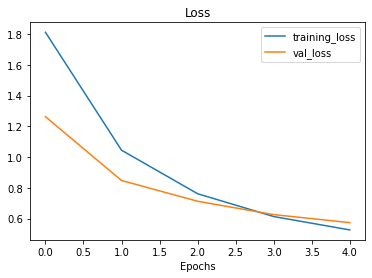

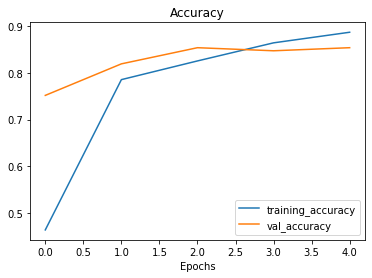

In [58]:
#Check out our model's Training curves
plot_loss_curves(history_10_percent)

#Getting the Feature vector from Trained model

Let's Demonstrate the Global Average Pooling 2D layer....

we have a tensor after our model goes through `bas_model` of shape (None,7,7,1280).


But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).


Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [59]:
#Define the input shape
input_shape=(1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")



#pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")



#check the shape of the different tensors
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor:{global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor:(1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor:(1, 3)


In [60]:
#Let's replicate the GlobalAveragePool2D layer

tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [61]:
#Try GlobalMaxpool2D layer

**Note:** one of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector**(a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D()  layer ) which can then be used to extract patterns out of for our own specific problem.

What is a Feature vector?
* A feature vector is a learned representation of the input data(a compressed form of the input data based on how the model see's it)

#Running a series of transfer learning experiments


we've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...  how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` -use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` -use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` -use fine tuning transfer learning on 100% of the training data with data augmentation


**Note:** throught all experiments the same test dataset will be used to evaluate our model.. this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [30]:
#download and unzip data
import wget
url="https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
filename=wget.download(url)
print(filename)

100% [......................................................................] 133612354 / 13361235410_food_classes_1_percent.zip


In [31]:
unzip_data("10_food_classes_1_percent.zip")

In [62]:
#Create train and test dirs
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [63]:
#How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [64]:
#setup data loaders
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)


test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                     label_mode="categorical",
                                                     image_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


##### Adding data augmentation right into the model


To add data augmentation right into our models,we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`


We can see the benefits of doing this within the Tensorflow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#:~:text=You%20can%20use%20the%20Keras%20preprocessing%20layers%20for,repeatedly%20to%20the%20same%20image.%20data_augmentation%20%3D%20tf.keras.Sequential%28%5B%26%5D


off the top our of heads,after reading the docs, the benefits of using data augmentation inside the model are:
* preprocessing of images(augmenting them)happens on the GPU(much faster) rather than the CPU.
* Image Data augmentation only happens during training,so we can still export our whole model and use it elsewhere.


when passed as a layer to a model data augmentation is automatically `turned on during training`(augments training data) but `turned off during inference`(does not augment testing data or new unseen data).

In [65]:
print(tf.__version__)

2.10.0


In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping,rotations,zooms, etc
data_augmentation=keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255)  #keep for models like Resnet50V2 but EfficientNet's having Rescaling builtin
    
],name="data_augmentation")

##### Visualize our data augmentation layer(and see what happens to our data)

Text(0.5, 1.0, 'Augmented random image from class :steak')

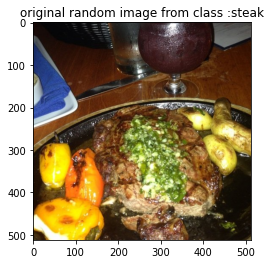

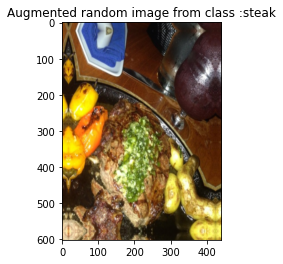

In [67]:
#View a random image and compare it to it's augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+"/"+random_image

#Read in the random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"original random image from class :{target_class}")


#Now let's plot our augmented random image
augmented_img=data_augmentation(img,training=True)
plt.figure()
plt.imshow(augmented_img/255)
plt.title(f"Augmented random image from class :{target_class}")

##### Model 1: Feature extraction transfer learning on 1% of data with data augmentatiom


In [68]:
#setup input shape and basemodel,freezing the basemodel layers
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create input layer
inputs=layers.Input(shape=input_shape,name="input_layer")


#Add in data augmentation Sequential model as a layer
x=data_augmentation(inputs)
print(x.shape)

#Give base_model the inputs (after augmentation) and don't train it
x=base_model(x,training=False)


#pool output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#put a dense layer on as the output
output=layers.Dense(10,activation="softmax",name="output_layer")(x)


#Make a model using the inputs and outputs
model_1=keras.Model(inputs,output)


#Compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])


#Fit the model
history_1_percent=model_1.fit(train_data_1_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_1_percent),
                             validation_data=test_data,
                             validation_steps=int(0.25*len(test_data)),
                              #track model training logs
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                    experiment_name="1_percent_data_aug")]
                             )

(None, 224, 224, 3)
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230315-071119
Epoch 1/5
3/3 [==============================] - 8s 1s/step - loss: 2.3868 - accuracy: 0.1286 - val_loss: 2.2402 - val_accuracy: 0.1628
Epoch 2/5
3/3 [==============================] - 1s 624ms/step - loss: 2.1342 - accuracy: 0.2286 - val_loss: 2.1155 - val_accuracy: 0.2582
Epoch 3/5
3/3 [==============================] - 2s 765ms/step - loss: 1.9421 - accuracy: 0.4000 - val_loss: 2.0007 - val_accuracy: 0.3470
Epoch 4/5
3/3 [==============================] - 1s 633ms/step - loss: 1.8050 - accuracy: 0.5000 - val_loss: 1.8945 - val_accuracy: 0.4128
Epoch 5/5
3/3 [==============================] - 1s 640ms/step - loss: 1.6186 - accuracy: 0.5857 - val_loss: 1.7815 - val_accuracy: 0.5000


In [69]:
#check out a model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [70]:
#Evaluate on full dataset
result_1_percent_data_aug=model_1.evaluate(test_data)
result_1_percent_data_aug

79/79 [==============================] - 4s 51ms/step - loss: 1.7768 - accuracy: 0.5024


[1.7767568826675415, 0.5023999810218811]

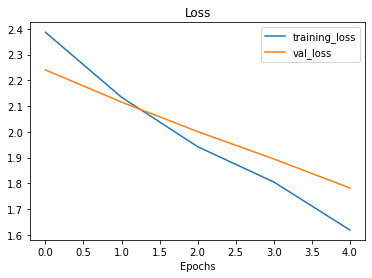

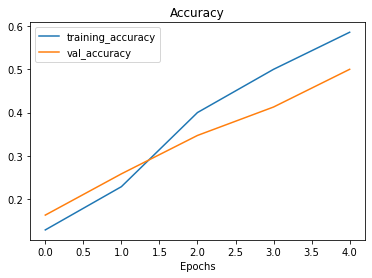

In [71]:
#How do the model with 1% of the and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

#### Model_2: Feature extraction Transfer Learning on 10% of data with data augmentation

In [72]:
#Create train and test directories
train_dir_10="10_food_classes_10_percent/train"
test_dir_10="10_food_classes_10_percent/test"

In [73]:
#How many images are we working with?
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [74]:
#setup the data loaders
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10,
                                                                      image_size=IMG_SIZE,
                                                                      batch_size=BATCH_SIZE,
                                                                      label_mode="categorical")

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir_10,
                                                          image_size=IMG_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [75]:
#setup input shape,base model and freezing the basemodel layers
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#create the input layer
inputs=layers.Input(shape=input_shape,name="Input_layer")

#Add in a data augmentation sequential model as a layer
x=data_augmentation(inputs)

#Give base model the inputs(after augmentation) and don't train it
x=base_model(x,training=False)


#pool output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#put a dense layer on as the output
output=layers.Dense(10,activation="softmax",name="output_layer")(x)

#make a model using input's and outputs
model_2=keras.Model(inputs,output)


#compile the model
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])



##### creating a ModelCheckpoint callback


the modelcheckpoint callback intermediately saves our model (the full model or just the weights) during Training. This is useful so we can come and start where we left off

In [76]:
#set checkpoint path
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"


#Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=False,
                                                      save_freq="epoch", #save every epoch
                                                      verbose=1)

In [77]:
#Fit the model
history_10_model_2=model_2.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                experiment_name="10_percent_data_aug"),checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230315-071201
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0157 - accuracy: 0.3480WARNING:tensorflow:Model was constructed with shape (512, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 1: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 12s 273ms/step - loss: 2.0157 - accuracy: 0.3480 - val_loss: 1.4542 - val_accuracy: 0.6579
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3358 - accuracy: 0.6653
Epoch 2: saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 6s 229ms/step - loss: 1.3358 - accuracy: 0.6653 - val_loss: 0.9

In [78]:
#what were model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 5s 50ms/step - loss: 0.5465 - accuracy: 0.8592


[0.5465488433837891, 0.8592000007629395]

In [79]:
#check model_2 results on all test data

results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 4s 51ms/step - loss: 0.6287 - accuracy: 0.8444


[0.6287195086479187, 0.8443999886512756]

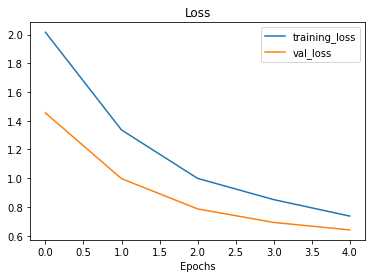

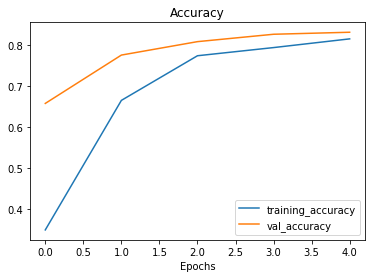

In [80]:
#plot model loss curves
plot_loss_curves(history_10_model_2)

#### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [81]:
#Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)

In [82]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 4s 49ms/step - loss: 0.6287 - accuracy: 0.8444


if the results from our previously evaluated model_2 match the loaded weights, everything has worked!

In [83]:
results_10_percent_data_aug==loaded_weights_model_results

False

In [84]:
#Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [85]:
#Check the difference between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[5.36441803e-07 0.00000000e+00]


* lower layers learns larger features and higher layers learn fine grain like(smaller) featurs

#### Model 3: Fine-tuning an exisiting model on 10% of the data

**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [86]:
#Layers in Loaded model
model_2.layers

In [87]:
#Are these layers trainable
for layer in model_2.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001EB9936C520> True
<keras.engine.sequential.Sequential object at 0x000001EB856F6A60> True
<keras.engine.functional.Functional object at 0x000001EBA3F5B3D0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001EBA3F2F640> True
<keras.layers.core.dense.Dense object at 0x000001EBA3F02160> True


In [88]:
for i,layer in enumerate(model_2.layers[2].layers):
    print(i,layer.name,layer.trainable)

0 input_5 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [89]:
#How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [90]:
#To begin fine tuning , let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable=True


#Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable=False
    
#Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(lr=0.0001), #when fine tuning you typically want to lower learning rate by 10x 
               metrics=["accuracy"])





C:\Users\gowth\anaconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Note:** when using fine-tuning it's best practice to lower your learning rate by some amount, How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10X(through different sources will claim other values).


A good resource for information on this is Ulmfit paper:https://arxiv.org/abs/1801.06146

In [91]:
#check which layers are tunable(trainable)
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_5 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [92]:
#Now we've unfrozen some of the layers closer to the top,how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [93]:
#Fine tune for another 5 epochs
initial_epochs=5
fine_tune_epochs=initial_epochs+5

#Refit the model(same as model_2 except with more trainable layers
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                            epochs=fine_tune_epochs,
                                            validation_data=test_data,
                                            validation_steps=int(0.25*len(test_data)),
                                            initial_epoch=history_10_model_2.epoch[-1],  #start training from previous last epoch
                                            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230315-071404
Epoch 5/10
24/24 [==============================] - 12s 256ms/step - loss: 0.6303 - accuracy: 0.8267 - val_loss: 0.5052 - val_accuracy: 0.8470
Epoch 6/10
24/24 [==============================] - 5s 210ms/step - loss: 0.4989 - accuracy: 0.8533 - val_loss: 0.4485 - val_accuracy: 0.8651
Epoch 7/10
24/24 [==============================] - 5s 211ms/step - loss: 0.4391 - accuracy: 0.8613 - val_loss: 0.4658 - val_accuracy: 0.8553
Epoch 8/10
24/24 [==============================] - 5s 210ms/step - loss: 0.3864 - accuracy: 0.8853 - val_loss: 0.4577 - val_accuracy: 0.8602
Epoch 9/10
24/24 [==============================] - 5s 207ms/step - loss: 0.3601 - accuracy: 0.8960 - val_loss: 0.4478 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 5s 214ms/step - loss: 0.3082 - accuracy: 0.9053 - val_loss: 0.4353 - val_accuracy: 0.8569


In [94]:
#Evaluate the fine-tuned model(model_3 which is actually model_2 fine_tuned for another 5 epochs)
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 4s 50ms/step - loss: 0.4299 - accuracy: 0.8548


In [95]:
results_10_percent_data_aug

[0.6287195086479187, 0.8443999886512756]

#### Comparing our model's results before and after fine-tuning


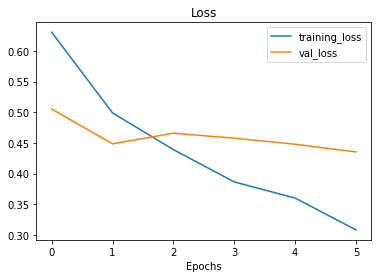

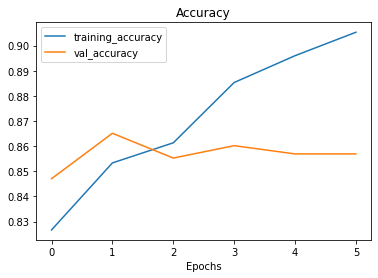

In [96]:
#check out the loss curves of fine tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once,however, we want something to compare one series of running `fit()` with another(e.g. before and after fine-tuning)

In [97]:
#Let's Create a function to compare training histories
def compare_historys(original_history,new_history,initial_epochs=5):
    """
    Compare two Tensorflow History objects
    """
    
    #get original history measurements
    acc=original_history.history["accuracy"]
    loss=original_history.history["loss"]
    
    val_acc=original_history.history["val_accuracy"]
    val_loss=original_history.history["val_loss"]
    
    
    #Combine original history metrics with new history metrics
    total_acc=acc+new_history.history["accuracy"]
    total_loss=loss+new_history.history["loss"]
    
    total_val_acc=val_acc+new_history.history["val_accuracy"]
    total_val_loss=val_loss+new_history.history["val_loss"]
    
    
    #Make plots for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc,label="Training accuracy")
    plt.plot(total_val_acc,label="Validation accuracy")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start fine tuning")
    plt.legend(loc="lower right")
    plt.title("training and Validation accuracy")
    
     #Make plots for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss,label="Training loss")
    plt.plot(total_val_loss,label="Validation loss")
    plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start fine tuning")
    plt.legend(loc="upper right")
    plt.title("training and Validation accuracy")

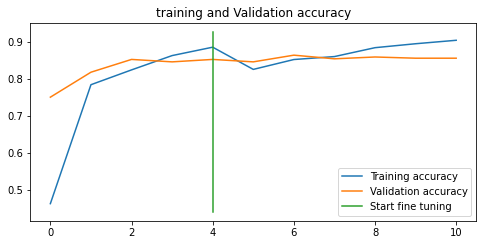

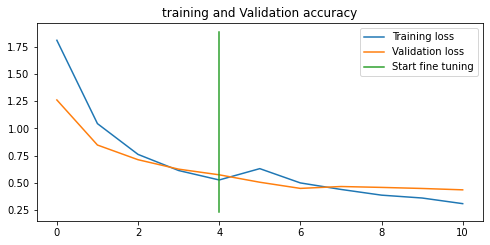

In [98]:
compare_historys(history_10_percent,
               history_fine_10_percent_data_aug,
               initial_epochs=5)

* Fine tuning usually works well for large amount of data, whereas feature extraction works for lesser amount of data

#### Model 4: Fine-tuning and existing model on all of the data

In [1]:
#Download and unzip 10 classes of Food101 data with all images
import wget
url="https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
filename=wget.download(url)
print(filename)

100% [......................................................................] 519183241 / 51918324110_food_classes_all_data (1).zip


In [2]:
#unzip the data


In [99]:
#set up train and test dir
train_dir="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [100]:
#How many images are we working with?
import os
for dir_path,dir_name,filename in os.walk("10_food_classes_all_data/"):
    print(f"There are {len(dir_name)} directories and {len(filename)} filenames in {dir_path}")

There are 2 directories and 0 filenames in 10_food_classes_all_data/
There are 10 directories and 0 filenames in 10_food_classes_all_data/test
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\chicken_curry
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\chicken_wings
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\fried_rice
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\grilled_salmon
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\hamburger
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\ice_cream
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\pizza
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\ramen
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\steak
There are 0 directories and 250 filenames in 10_food_classes_all_data/test\sushi
There are

In [101]:
#use custom function from helper function
walk_through_dir("10_food_classes_all_data/")

There are 2 directories and 0 images in '10_food_classes_all_data/'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\sushi'.
There are

In [102]:
#setup data input
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              image_size=IMG_SIZE,
                                                                              batch_size=BATCH_SIZE,
                                                                              label_mode="categorical")

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             image_size=IMG_SIZE,
                                                             batch_size=BATCH_SIZE,
                                                             label_mode="categorical")


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments(all experiments have used the same test dataset)


Let's verify this..

In [103]:
#Evaluate model 2(this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 4s 50ms/step - loss: 0.4299 - accuracy: 0.8548


[0.4298718273639679, 0.8547999858856201]

In [104]:
results_10_percent_data_aug

[0.6287195086479187, 0.8443999886512756]

To train a fine-tuning model(model_4) we need to revert model_2 back to it's feature extraction weights.

In [105]:
#Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"
model_2.load_weights(checkpoint_path)

In [106]:
#let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 4s 50ms/step - loss: 0.6287 - accuracy: 0.8444


[0.62871915102005, 0.8443999886512756]

In [107]:
#check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6287195086479187, 0.8443999886512756]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation(model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen(model_3).
3. Saved the results and training logs each time
4. Reload the model from step 1 to do the same steps as step2 except this time we're going to use all of the data (model_4).


In [108]:
#check which layers are tunable in the whole model
for layer_number,layer in enumerate(model_2.layers):
    print(layer_number,layer.name,layer.trainable)

0 Input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [109]:
#Let's drill into our base_model(efficientnetb0) and see what layers are trainable
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_5 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [38]:
#compile the model
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [110]:
#Continue to train and fine-tune the model to our data(100% of traing data)
initial_epochs=5
fine_tune_epochs=initial_epochs+5

history_fine_10_classes_full=model_2.fit(train_data_10_classes_full,
                                        epochs=fine_tune_epochs,
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        initial_epoch=history_10_model_2.epoch[-1],
                                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                              experiment_name="full_10_classes_fine_tune")]
                                        )

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20230315-071555
Epoch 5/10
235/235 [==============================] - 46s 194ms/step - loss: 0.6153 - accuracy: 0.8073 - val_loss: 0.3344 - val_accuracy: 0.8892
Epoch 6/10
235/235 [==============================] - 45s 192ms/step - loss: 0.4237 - accuracy: 0.8660 - val_loss: 0.2768 - val_accuracy: 0.9120
Epoch 7/10
235/235 [==============================] - 46s 194ms/step - loss: 0.3244 - accuracy: 0.8933 - val_loss: 0.2812 - val_accuracy: 0.9084
Epoch 8/10
235/235 [==============================] - 47s 202ms/step - loss: 0.2595 - accuracy: 0.9139 - val_loss: 0.2750 - val_accuracy: 0.9128
Epoch 9/10
235/235 [==============================] - 44s 188ms/step - loss: 0.2306 - accuracy: 0.9208 - val_loss: 0.2767 - val_accuracy: 0.9160
Epoch 10/10
235/235 [==============================] - 44s 187ms/step - loss: 0.1804 - accuracy: 0.9407 - val_loss: 0.2616 - val_accuracy: 0.9208


In [111]:
#Let's evaluate on all of the test data
results_fine_tune_full_data=model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 4s 51ms/step - loss: 0.2616 - accuracy: 0.9208


[0.26159432530403137, 0.920799970626831]

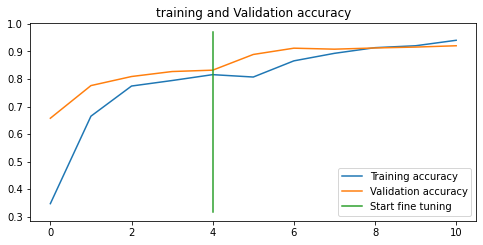

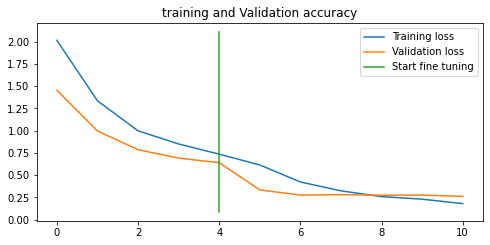

In [112]:
#How did fine tuning go with more data?
compare_historys(original_history=history_10_model_2,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)

In [ ]:
Tensorboard logs check